In [1]:
## processing
import numpy as np
import pandas as pd
from sklearn import linear_model

## custom scripts
import sys
sys.path.insert(1, '../scripts')
#import footprint as fp
#import footprint_to_sites as f2s

# visualization
import matplotlib.pyplot as plt

In this notebook, we take in sequencing data in the form of RNA and DNA counts for each promoter variant and compute information footprint by calculating mutual information. We will first test the code on experimental datasets and then we will generate information footprint based on synthetic datasets.

The mutual information between two random variables $X$ and $Y$ is defined as
$$
I(X;Y) = \sum_{y \in Y} \sum_{x \in X} P_{X,Y}(x,y) \log{(\frac{P_{X,Y}(x,y)}{P_X(x)P_Y(y)})},
$$
where $P_X$ is the marginal probability distribution of $X$, $P_Y$ is the marginal probability distribution of $Y$, and $P_{X,Y}$ is the joint probability distribution between $X$ and $Y$.

Here, the two random variables that we care about are base identity and expression levels. We explore different ways of representing base identity and expression levels in probabilistic terms and ask which definition of mutual information produces the "best" information footprint.

There are two ways of representing base identity, $b$. If we are interested in which nucleotide is at each position in each promoter variant, then $b$ can be one of the four nucleotides, A, T, C, G. Alternatively, we might only be concerned with whether a mutation has occured i.e. whether the base identity at position $i$ in the promoter variant is different from the base identity in the wild type sequence. In this case, $b$ can take the values of
$$
b = 
\begin{cases}
    0, & \text{if the base is mutated} \\
    1, & \text{if the base is wild type}.
\end{cases}
$$. 

To represent expression levels as a probability distribution, we group sequences in each range of expression levels into discrete bins. The key question here is then what is the ideal method of binning the sequences. We begin by normalizing expression levels (RNA/DNA count) and choosing $n$ equal sized bins for the normalized counts.

### Loading sequencing data

The data is taken from `/RegSeq/data/sequencing_data/ykgE_dataset_combined.csv`, which contains DNA count (`ct_0`), RNA count (`ct_1`), and the total count (`ct`) for each promoter variant.

In [3]:
fpath = '../../data/ykgE_dataset_combined.csv'
df_ykgE = pd.read_csv(fpath)
df_ykgE.head()

,ct,ct_0,ct_1,seq
0,1.0,1.0,0.0,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGA...
1,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...
2,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...
3,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...
4,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...


### Counting mutations

In [2]:
def match_seqs(mut_list, wtseq):

    wtlist = np.array(list(wtseq))
    seqlen = len(wtseq)
    all_mutarr = np.zeros((len(mut_list), seqlen))

    for i, mut in enumerate(mut_list):
        s = np.array(list(mut))
        all_mutarr[i, :seqlen] = (wtlist != s)
    
    return all_mutarr

In [3]:
wtseq = 'TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGG'

In [ ]:
all_mutarr = match_seqs(df['seq'].values, wtseq)

### Making information footprint

<AxesSubplot:xlabel='position', ylabel='Information (bits)'>

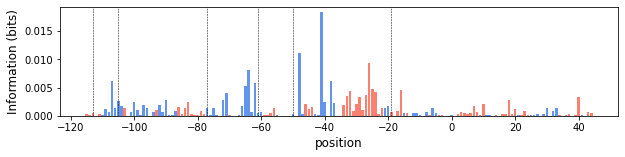

In [4]:
fp.plot_mi_footprint(fpath, wtseq, color=True, output_file='./plots/ykgE_footprint.png')

<AxesSubplot:xlabel='position', ylabel='Information (bits)'>

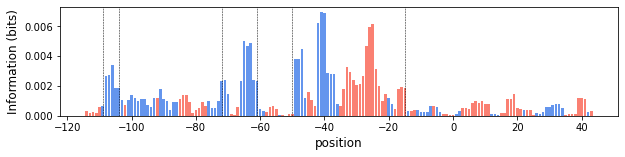

In [7]:
fp.plot_mi_footprint(fpath, wtseq, color=True, output_file='./plots/ykgE_footprint_rolling.png', rolling_average=True, windowsize=3)

<AxesSubplot:xlabel='position', ylabel='Information (bits)'>

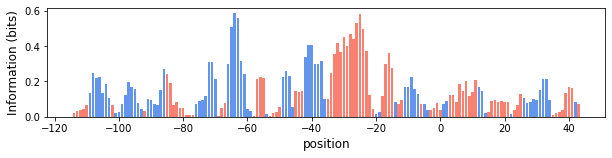

In [5]:
fp.plot_linreg_footprint(fpath, wtseq, pseudocount=0.1)

## Testing on simulated LacI data

In [4]:
fpath = '../../data/synthetic_datasets/lacI_synthetic_dataset.csv'
df_lacI = pd.read_csv(fpath)
df_lacI.head()

,seq,pbound,ct_0,ct_1,ct
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.006352,14.0,0.0,14.0
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.003205,20.0,0.0,20.0
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.024610,3.0,0.0,3.0
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.006534,8.0,0.0,8.0
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.027950,19.0,2.0,21.0


In [5]:
wtseq = 'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [6]:
lacI_footprint = fp.mi_footprint(fpath, wtseq)

<AxesSubplot:xlabel='position', ylabel='Information (bits)'>

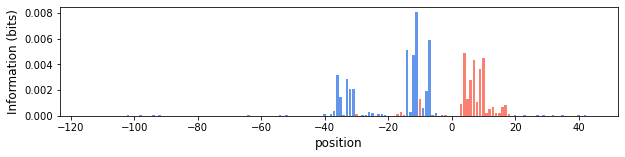

In [7]:
fp.plot_mi_footprint(fpath, wtseq, color=True,
                     output_file='./fig.png')

<AxesSubplot:xlabel='position', ylabel='Information (bits)'>

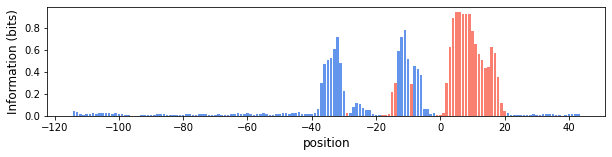

In [18]:
fp.plot_linreg_footprint(fpath, wtseq, center=True, pseudocount=0.5)

## Testing on simulated LacI data - small dataset

In [6]:
fpath = '../../data/synthetic_datasets/lacI_synthetic_dataset_small.csv'
df_lacI = pd.read_csv(fpath)
df_lacI.head()

,seq,pbound,ct_0,ct_1,ct
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAg...,0.003133,14.0,0.0,14.0
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGtGCGCAACGCAgTTAA...,0.018642,21.0,1.0,22.0
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTcAGgGCAACGCAcTTAg...,0.003050,10.0,0.0,10.0
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGaGAGCGCAAaGgAATTAA...,0.032503,3.0,0.0,3.0
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGgGAaCGCggCGCAATTAA...,0.000658,6.0,0.0,6.0


In [7]:
wtseq = 'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [8]:
lacI_footprint = fp.mi_footprint(fpath, wtseq)

/Users/rosalindpan/rpgroup/thermo_seq/code/analysis/../scripts/footprint.py:87: RuntimeWarning: divide by zero encountered in log2
  mi += p_mut_rna[i] * np.log2(p_mut_rna[i] / (p_mut_tot[:, i][1] * seq_cnt[1]))
/Users/rosalindpan/rpgroup/thermo_seq/code/analysis/../scripts/footprint.py:87: RuntimeWarning: invalid value encountered in double_scalars
  mi += p_mut_rna[i] * np.log2(p_mut_rna[i] / (p_mut_tot[:, i][1] * seq_cnt[1]))


/Users/rosalindpan/rpgroup/thermo_seq/code/analysis/../scripts/footprint.py:87: RuntimeWarning: divide by zero encountered in log2
  mi += p_mut_rna[i] * np.log2(p_mut_rna[i] / (p_mut_tot[:, i][1] * seq_cnt[1]))
/Users/rosalindpan/rpgroup/thermo_seq/code/analysis/../scripts/footprint.py:87: RuntimeWarning: invalid value encountered in double_scalars
  mi += p_mut_rna[i] * np.log2(p_mut_rna[i] / (p_mut_tot[:, i][1] * seq_cnt[1]))


<AxesSubplot:xlabel='position', ylabel='Information (bits)'>

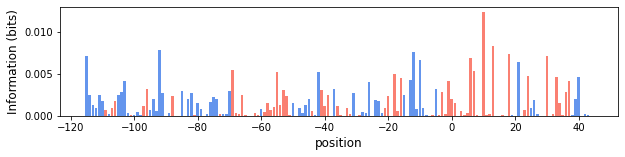

In [9]:
fp.plot_mi_footprint(fpath, wtseq, color=True)

## Testing on simulated LacI data - small dataset with uniform DNA count

In [10]:
fpath = '../../data/synthetic_datasets/lacI_synthetic_dataset_small_uniform.csv'
df_lacI = pd.read_csv(fpath)
df_lacI.head()

,seq,pbound,ct_0,ct_1,ct
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000667,100.0,0.0,100.0
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACtCAAaTAg...,0.008716,100.0,4.0,104.0
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGcGAGCGgAACGCAATTAA...,0.020056,100.0,10.0,110.0
3,ACAGGTTTCCCGACTGGAAAGCGGGCAcTGAaCGCAACGCAATTAA...,0.028442,100.0,14.0,114.0
4,ACAGGTTTCCCGACTGGAAAGCGGtCgGTGAGCGCAACGCAATTAA...,0.023784,100.0,11.0,111.0


In [11]:
wtseq = 'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [12]:
lacI_footprint = fp.mi_footprint(fpath, wtseq)

<AxesSubplot:xlabel='position', ylabel='Information (bits)'>

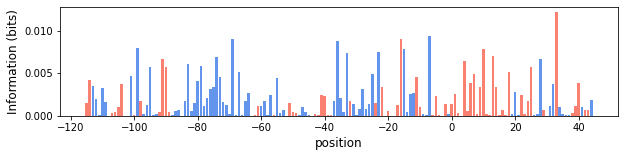

In [13]:
fp.plot_mi_footprint(fpath, wtseq, color=True)